# DBSCAN
> Density-Based Spatial Clustering of Applications with Noise

> 밀도 기반 클러스터링 알고리즘

In [11]:
import torch
import torchvision.transforms as transforms
from torchvision import datasets
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

In [4]:
# MNIST 데이터셋
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x:x.view(-1))])
train_dataset = datasets.MNIST(root = '/.data', train = True, download = True, transform = transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 1000, shuffle = False)

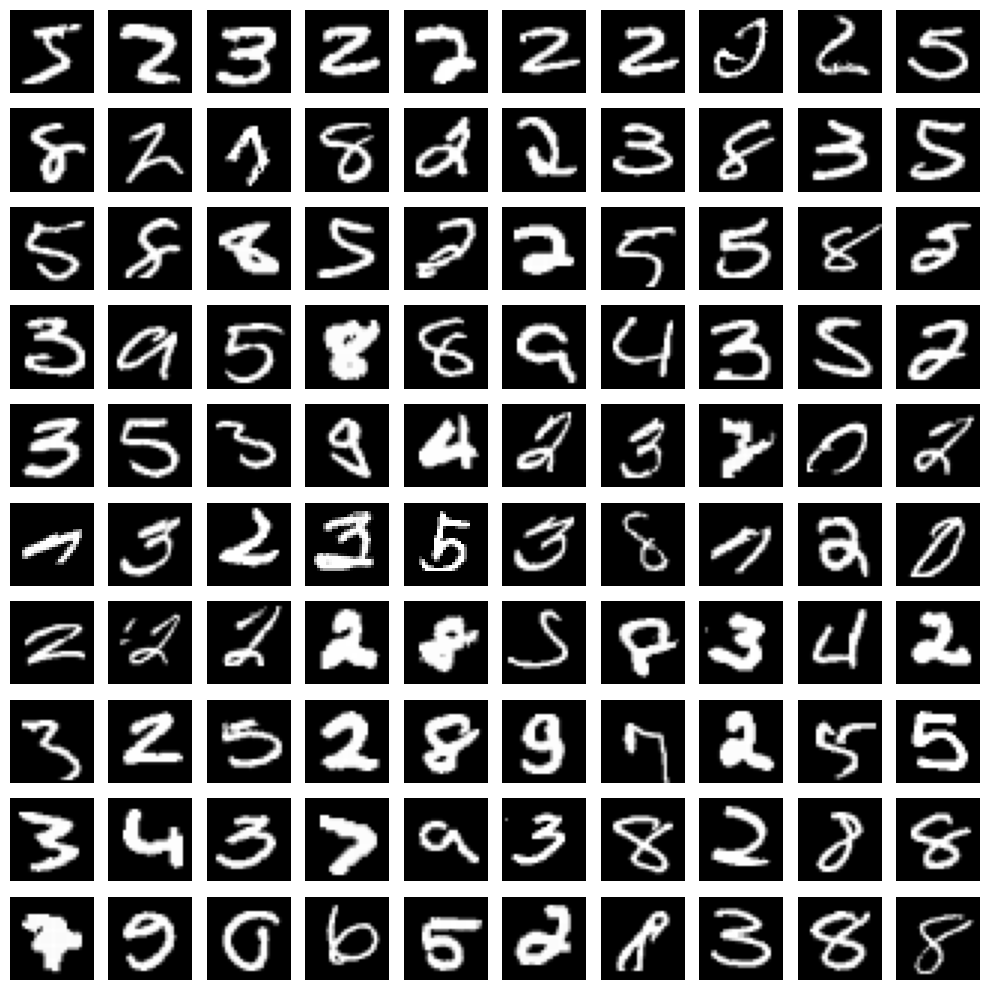

--------------------------------------------------
Number of outliers detected : 4041
--------------------------------------------------
Outlier label counts (sorted) : 
Label 2 : 953
Label 8 : 923
Label 3 : 593
Label 5 : 578
Label 0 : 232
Label 6 : 213
Label 4 : 211
Label 9 : 210
Label 7 : 110
Label 1 : 18


In [47]:
data = []
labels = []

for images, lbls in train_loader:
    data.append(images.numpy())
    labels.append(lbls.numpy())

data = np.concatenate(data)
labels = np.concatenate(labels)

# DBSCAN parameters
epsilon = 6
min_samples = 5

# train
dbscan = DBSCAN(eps = epsilon, min_samples = min_samples)
db_labels = dbscan.fit_predict(data)

# outliers label (-1)
outliers = np.where(db_labels == -1)[0]
outliers_data = data[outliers]
outliers_labels = labels[outliers]

# 이상치 이미지 출력
def outliers_images(images, ncols = 10):
    n_images = len(images)
    n_rows = (n_images + ncols - 1) // ncols
    plt.figure(figsize = (ncols, n_rows))
    for i in range(n_images):
        plt.subplot(n_rows, ncols, i + 1)
        plt.imshow(images[i].reshape(28, 28), cmap = 'gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

if len(outliers) > 0:
    outliers_images(outliers_data[:100])

    print('-' * 50)
    print(f'Number of outliers detected : {len(outliers)}')
    print('-' * 50)

    outliers_count = Counter(outliers_labels)
    sorted_outlier_count = sorted(outliers_count.items(), key = lambda x: x[1], reverse = True)

    print('Outlier label counts (sorted) : ')
    for label, count in sorted_outlier_count:
        print(f'Label {label} : {count}')
else:
    print('No outliers detected')

# DBSCAN(PCA 적용)
> 주성분 분석 적용

> 성능 저하를 방지하기 위해 차원 축소 진행

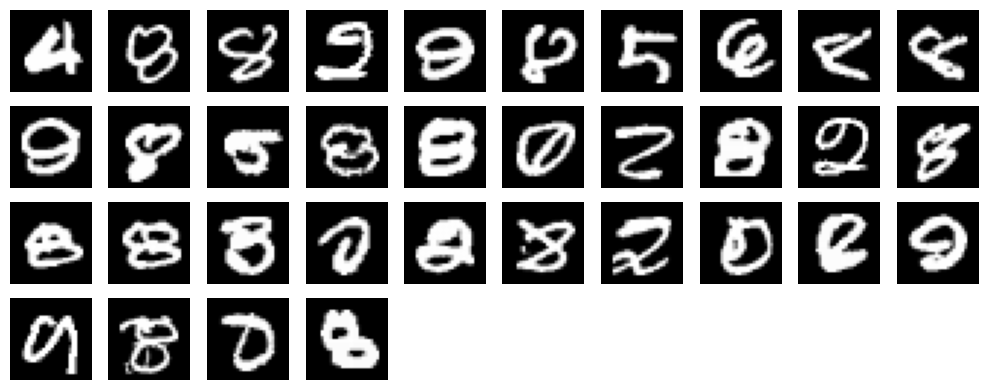

--------------------------------------------------
Number of outliers detected : 34
--------------------------------------------------
Outlier label counts (sorted) : 
Label 8 : 16
Label 2 : 5
Label 9 : 4
Label 0 : 4
Label 5 : 2
Label 4 : 1
Label 6 : 1
Label 3 : 1


In [45]:
import torch
import torchvision.transforms as transforms
from torchvision import datasets
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# MNIST 데이터셋
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x:x.view(-1))])
train_dataset = datasets.MNIST(root = '/.data', train = True, download = True, transform = transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 1000, shuffle = False)

data = []
labels = []

for images, lbls in train_loader:
    data.append(images.numpy())
    labels.append(lbls.numpy())

data = np.concatenate(data)
labels = np.concatenate(labels)

# PCA 적용
pca = PCA(n_components = 50)
data_pca = pca.fit_transform(data)

# DBSCAN parameters
epsilon = 6
min_samples = 5

# train
dbscan = DBSCAN(eps = epsilon, min_samples = min_samples)
db_labels = dbscan.fit_predict(data_pca)

# outliers label (-1)
outliers = np.where(db_labels == -1)[0]
outliers_data = data[outliers]
outliers_labels = labels[outliers]

# 이상치 이미지 출력
def outliers_images(images, ncols = 10):
    n_images = len(images)
    n_rows = (n_images + ncols - 1) // ncols
    plt.figure(figsize = (ncols, n_rows))
    for i in range(n_images):
        plt.subplot(n_rows, ncols, i + 1)
        plt.imshow(images[i].reshape(28, 28), cmap = 'gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

if len(outliers) > 0:
    outliers_images(outliers_data[:100])

    print('-' * 50)
    print(f'Number of outliers detected : {len(outliers)}')
    print('-' * 50)

    outliers_count = Counter(outliers_labels)
    sorted_outlier_count = sorted(outliers_count.items(), key = lambda x: x[1], reverse = True)

    print('Outlier label counts (sorted) : ')
    for label, count in sorted_outlier_count:
        print(f'Label {label} : {count}')
else:
    print('No outliers detected')

# 최적의 Epsilon 찾기
> 시각적인 방법 (KNN 거리 그래프)

> 2차 미분을 이용한 방법

> KneeLocator 라이브러리를 사용한 방법

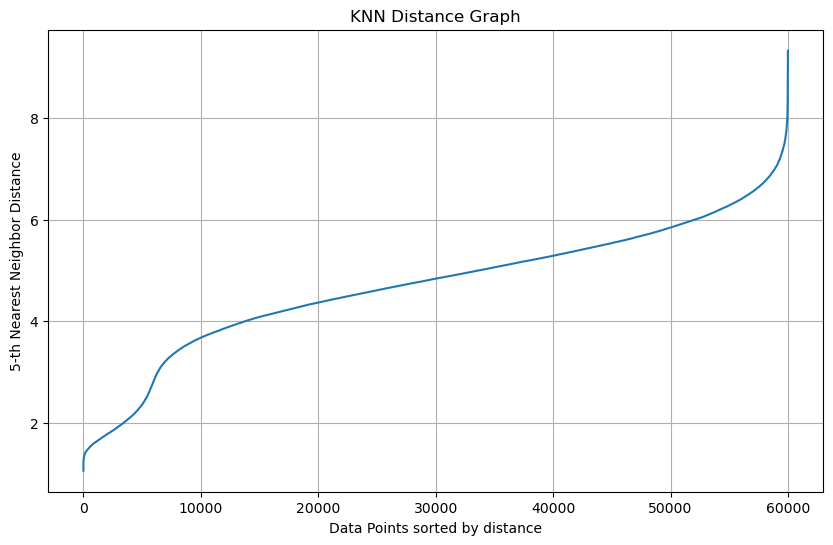

In [52]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x:x.view(-1))])
train_dataset = datasets.MNIST(root = '/.data', train = True, download = True, transform = transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 1000, shuffle = False)

data = []
labels = []

for images, lbls in train_loader:
    data.append(images.numpy())
    labels.append(lbls.numpy())

data = np.concatenate(data)
labels = np.concatenate(labels)

k = 5
nbrs = NearestNeighbors(n_neighbors = k).fit(data)
distances, indices = nbrs.kneighbors(data)

distances = np.sort(distances[:, k-1], axis = 0)
./
plt.figure(figsize = (10, 6))
plt.plot(distances)
plt.title('KNN Distance Graph')
plt.xlabel('Data Points sorted by distance')
plt.ylabel(f'{k}-th Nearest Neighbor Distance')
plt.grid()
plt.show()

In [54]:
import numpy as np
from scipy.signal import argrelextrema

def second_derivative(y):
    return np.diff(np.diff(y))

second_deriv = second_derivative(distances)

local_maxima = argrelextrema(second_deriv, np.greater)[0]

optimal_eps = distances[local_maxima]
print(f"Optimal epsilon values from second derivative method : {optimal_eps}")

Optimal epsilon values from second derivative method : [1.22224665 1.24318063 1.25080824 ... 8.48498249 8.58523273 8.64210033]


In [56]:
from kneed import KneeLocator

kneedle = KneeLocator(range(len(distances)), distances, curve = 'convex', direction = 'increasing')
optimal_epsilon = distances[kneedle.elbow]

print(f'Optimal epsilon using KneeLocator : {optimal_epsilon}')

Optimal epsilon using KneeLocator : 7.457669734954834
